## AmazonReview: A Machine Learning approach

In [15]:
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
 
# Read the CSV file
train_df = pd.read_csv('Training.csv')



=== Processing Cutoff 1 ===

--- Logistic Regression ---
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8379582048646796
F1 Score: 0.7293704525497083
ROC AUC: 0.859237156269896


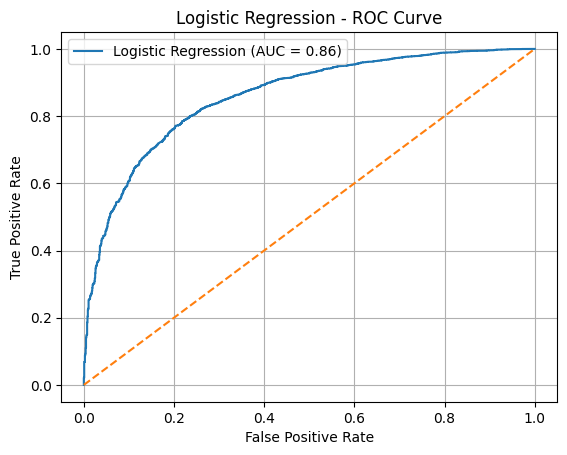

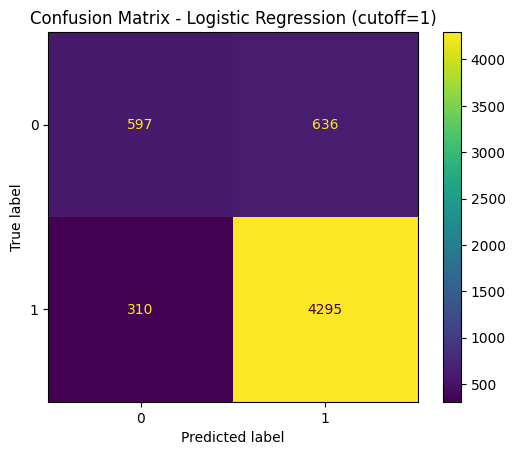


--- Perceptron ---
Best Params: {'alpha': 0.0001, 'eta0': 0.1}
Accuracy: 0.8107228502911956
F1 Score: 0.7040452729313772
ROC AUC: 0.8005247478630108


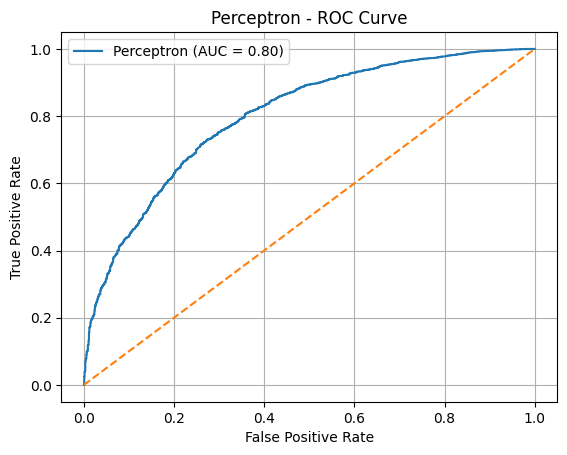

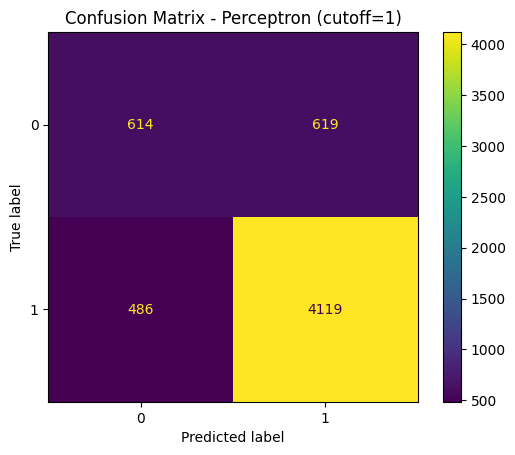


--- Linear SVM ---
Best Params: {'C': 1}
Accuracy: 0.8365878725590956
F1 Score: 0.7294276788615295
ROC AUC: 0.851333796527453


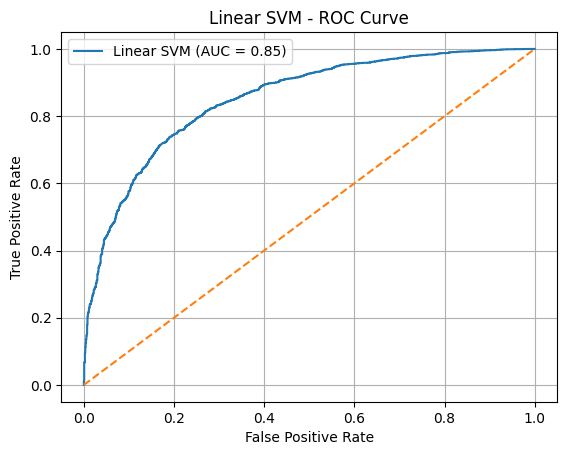

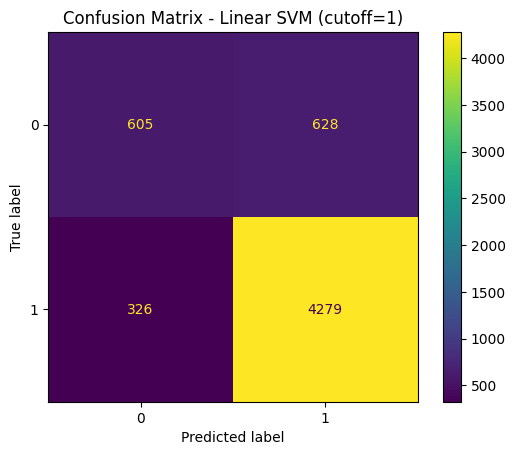


=== Processing Cutoff 2 ===

--- Logistic Regression ---
Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8050702295306612
F1 Score: 0.7944331850392312
ROC AUC: 0.8885695586637876


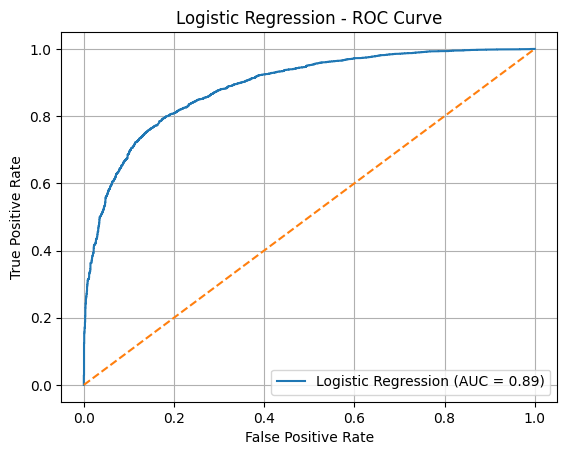

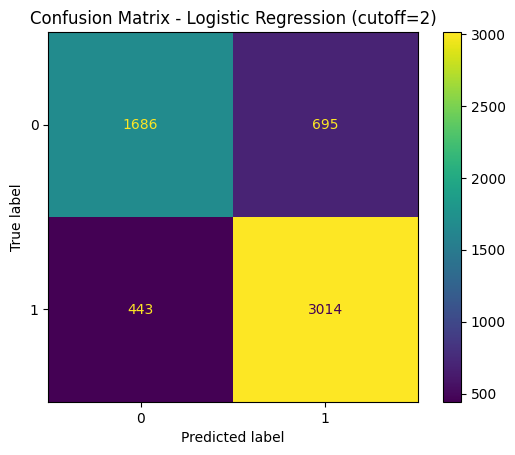


--- Perceptron ---
Best Params: {'alpha': 0.0001, 'eta0': 0.1}
Accuracy: 0.7485440219253169
F1 Score: 0.7418805869455221
ROC AUC: 0.8239631389032618


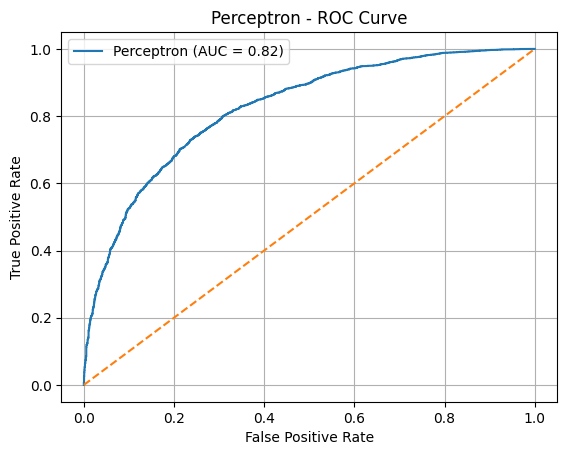

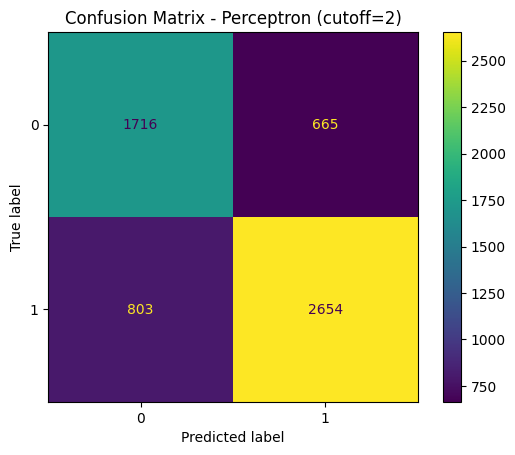


--- Linear SVM ---
Best Params: {'C': 0.1}
Accuracy: 0.8074683110654334
F1 Score: 0.7970287480681592
ROC AUC: 0.8889121610104679


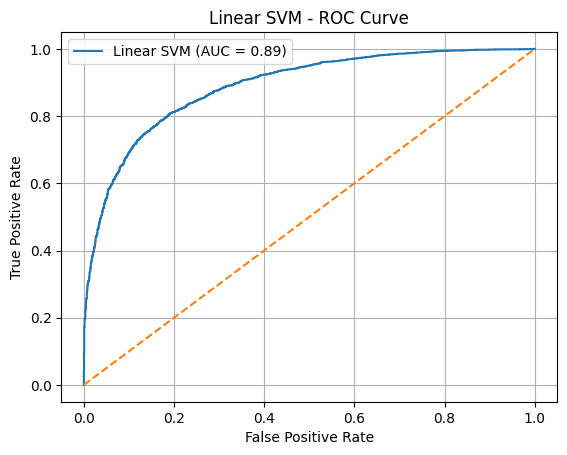

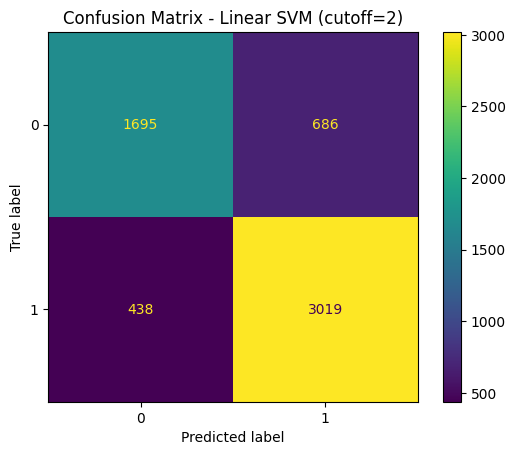


=== Processing Cutoff 3 ===

--- Logistic Regression ---
Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8307639602603631
F1 Score: 0.8159163675172213
ROC AUC: 0.9032100979711486


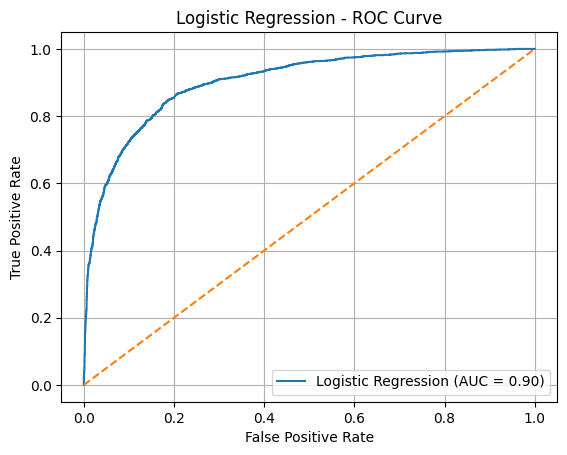

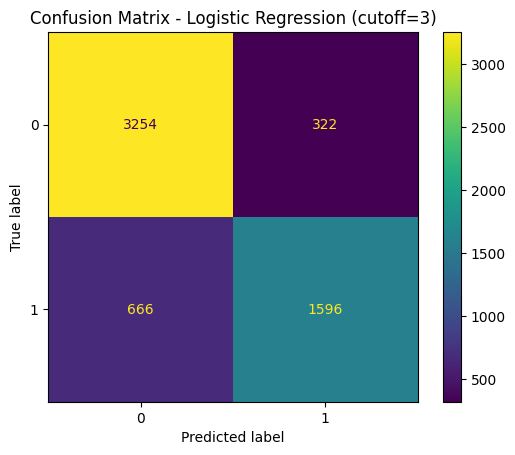


--- Perceptron ---
Best Params: {'alpha': 0.0001, 'eta0': 0.1}
Accuracy: 0.7863994518670777
F1 Score: 0.7723356867968485
ROC AUC: 0.8573386630983251


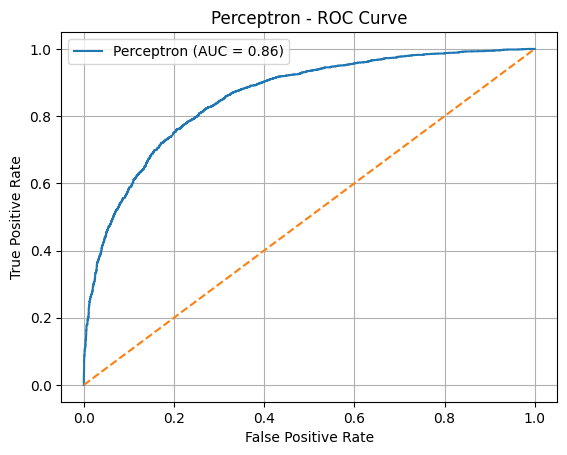

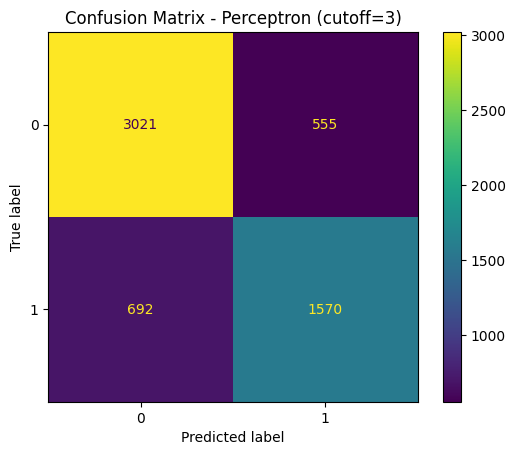


--- Linear SVM ---
Best Params: {'C': 0.1}
Accuracy: 0.8300787941075711
F1 Score: 0.8149746869171329
ROC AUC: 0.9035817177884986


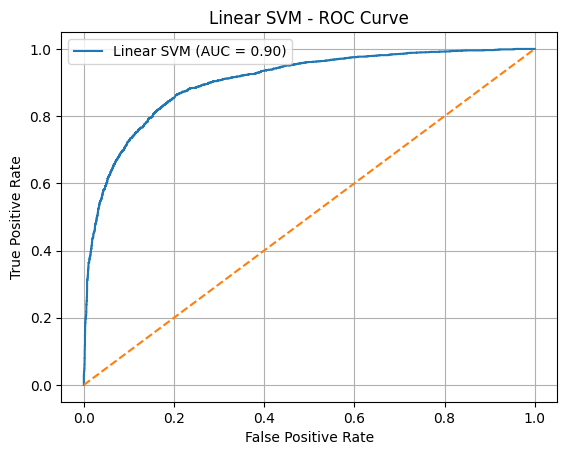

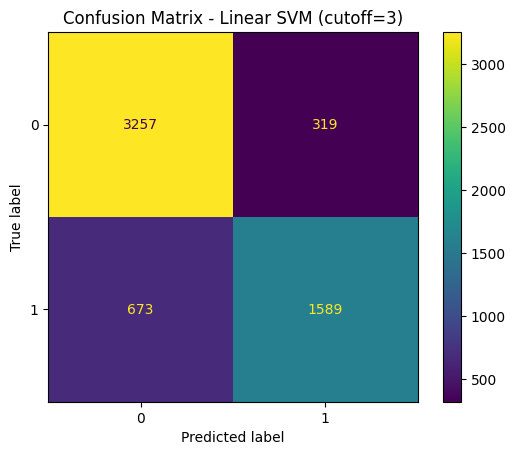


=== Processing Cutoff 4 ===

--- Logistic Regression ---
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8530318602261048
F1 Score: 0.7415733050028974
ROC AUC: 0.8797938007021506


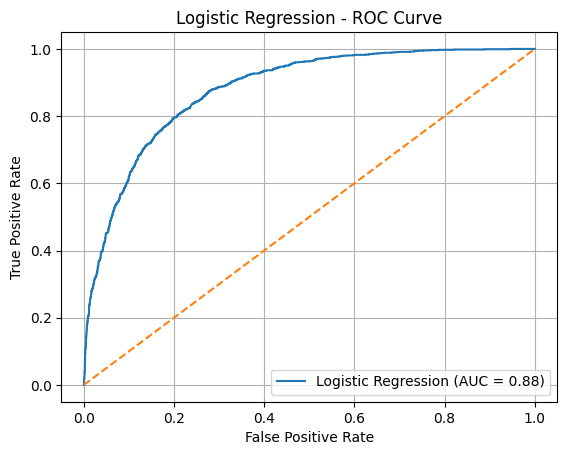

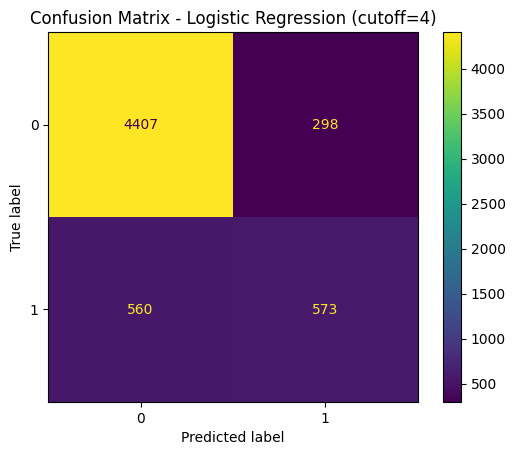


--- Perceptron ---
Best Params: {'alpha': 0.0001, 'eta0': 0.1}
Accuracy: 0.8175745118191161
F1 Score: 0.7014472208719723
ROC AUC: 0.8284405709124301


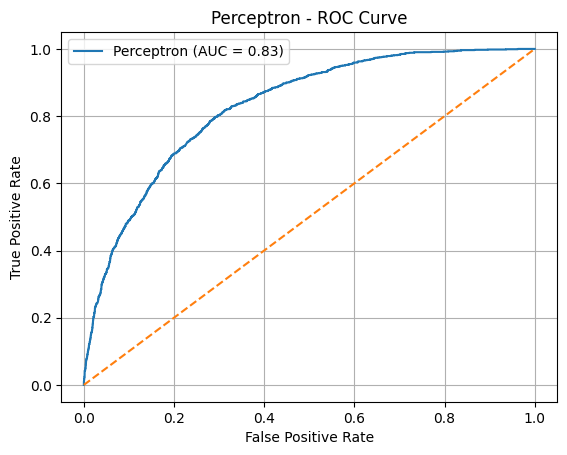

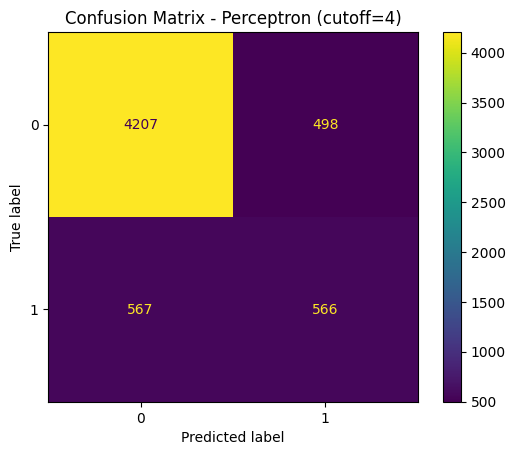


--- Linear SVM ---
Best Params: {'C': 1}
Accuracy: 0.8504624871531347
F1 Score: 0.7404295051353875
ROC AUC: 0.8720076761965684


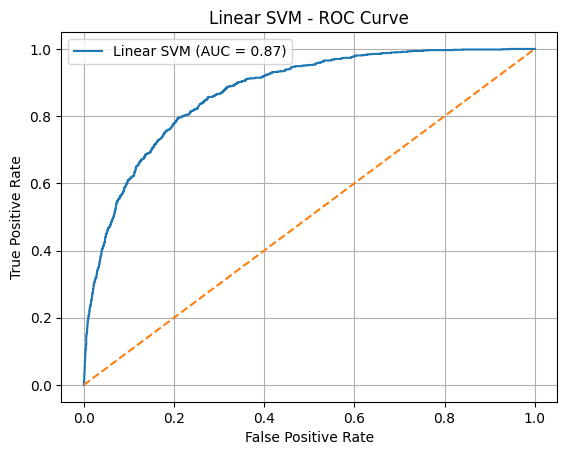

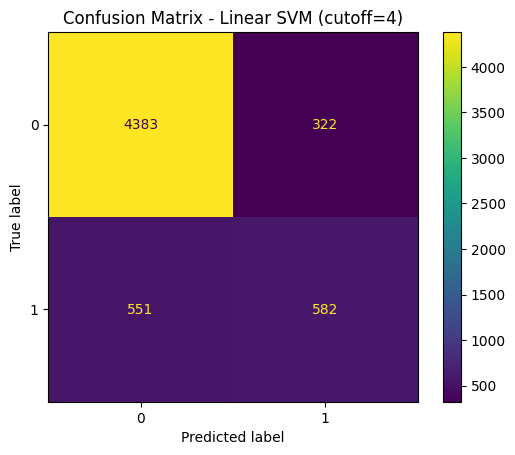

In [17]:
#Binary Classification

##Vectorize text
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.8)
X = vectorizer.fit_transform(train_df['reviewText'])

def evaluate_models_for_cutoff(train_df, cutoff):

    print(f"\n=== Processing Cutoff {cutoff} ===")
    y = (train_df['overall'] > cutoff).astype(int)

    # Train/Validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results_log = []  # each entry will be a dictionary of met


    def evaluate_model(name, model, param_grid, use_proba=True):
        print(f"\n--- {name} ---")
        grid = GridSearchCV(model, param_grid, scoring='f1_macro', cv=5)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print("Best Params:", grid.best_params_)
        

        y_pred = best_model.predict(X_val)
        print("Accuracy:", accuracy_score(y_val, y_pred))
        print("F1 Score:", f1_score(y_val, y_pred, average='macro'))

        if use_proba:
            if hasattr(best_model, "predict_proba"):
                y_scores = best_model.predict_proba(X_val)[:, 1]
            elif hasattr(best_model, "decision_function"):
                y_scores = best_model.decision_function(X_val)
            else:
                y_scores = None

            if y_scores is not None:
                auc_score = roc_auc_score(y_val, y_scores)
                print("ROC AUC:", auc_score)

                fpr, tpr, _ = roc_curve(y_val, y_scores)
                plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
                plt.plot([0, 1], [0, 1], linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f"{name} - ROC Curve")
                plt.legend()
                plt.grid()
                plt.show()

            
        ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
        plt.plot()
        plt.title(f'Confusion Matrix - {name} (cutoff={cutoff})')
        plt.show()
        
        return {
                "Model": name,
                "Cutoff": cutoff,
                "Accuracy": accuracy_score(y_val, y_pred),
                "F1 Score": f1_score(y_val, y_pred, average='macro'),
                "AUC": roc_auc_score(y_val, y_scores) if use_proba and y_scores is not None else None,
                "Best Params": grid.best_params_,
                "Best Model": grid.best_estimator_
                }
       
    # Best Model
    best_score=0
    best_model=None
    
    # Logistic Regression
    result_LR = evaluate_model(
        name="Logistic Regression",
        model=LogisticRegression(max_iter=1000),
        param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs']}
    )
    results_log.append(result_LR)
    if result_LR["F1 Score"]> best_score:
        best_score=result_LR["F1 Score"]
        best_model=result_LR['Best Model']

    # Perceptron
    result_PR = evaluate_model(
        name="Perceptron",
        model=Perceptron(max_iter=1000),
        param_grid={'alpha': [0.0001, 0.001], 'eta0': [0.1, 1.0]},
        use_proba=True
    )
    results_log.append(result_PR)
    if result_PR["F1 Score"]> best_score:
        best_score=result_PR["F1 Score"]
        best_model=result_PR['Best Model']

    # SVM
    result_SVM = evaluate_model(
        name="Linear SVM",
        model=LinearSVC(),
        param_grid={'C': [0.1, 1, 10, 100]},
        use_proba=True
    )

    results_log.append(result_SVM)
    if result_SVM["F1 Score"]> best_score:
        best_score=result_SVM["F1 Score"]
        best_model=result_SVM['Best Model']

    return best_model
    #return results_log



# Run evaluations for all cutoffs
best_models={}
for cutoff in [1, 2, 3, 4]:
    best_model=evaluate_models_for_cutoff(train_df, cutoff)
    best_models[cutoff]=best_model


### Kaggle Binary Classification

In [19]:
test_df = pd.read_csv('Test.csv')

#Print best model
print("The Best model result is:", best_models)

#Based on the results above, the best model for cutoff of 1 through 4 is Logistic Regression
best_model_cutoff1=best_models[4]

#Predict the label of the test samples
test_text = vectorizer.transform(test_df['reviewText'])

test_predicted = best_model_cutoff1.predict(test_text) #predicted test values
test_submission = pd.DataFrame({
    'id': test_df.index,          # or test_df['your_id_column'] if specified
    'binary_split_4': test_predicted
})
test_submission.to_csv('test_submission_cutoff4.csv', index=False)


The Best model result is: {1: LinearSVC(C=1), 2: LinearSVC(C=0.1), 3: LogisticRegression(C=1, max_iter=1000), 4: LogisticRegression(C=10, max_iter=1000)}


## 4. Multiclass classification
#### 4.1 Setup
We extended the task to predict the exact rating (1–5). Models were trained using one-vs-rest
strategy with label binarization for ROC analysis.

#### 4.2 Evaluation Metrics
* Confusion Matrix
* Accuracy
* Macro F1 Score
* ROC and AUC (One-vs-Rest)


#### 4.5 Results


=== Processing  ===

--- Logistic Regression ---
Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.49246317231928743
F1 Score: 0.48788770409430227
ROC AUC: 0.8099107706380106


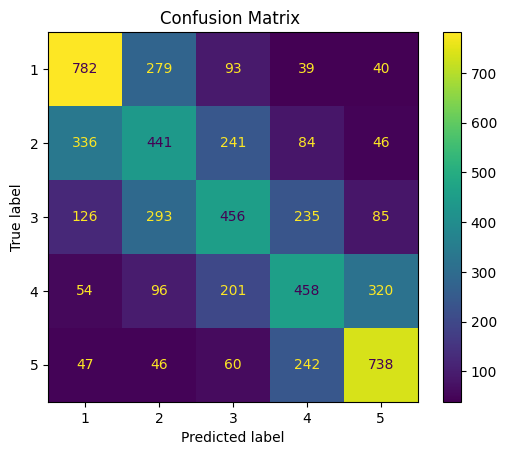


--- Random Forest ---
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.45940390544707094
F1 Score: 0.45350126005993496
ROC AUC: 0.7759543891234864


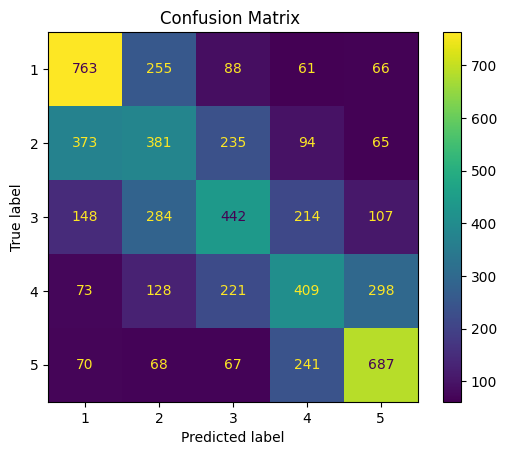


--- Naive Bayes ---
Best Params: {'alpha': 1.0}
Accuracy: 0.4936622130866735
F1 Score: 0.49093923273731177
ROC AUC: 0.806667116806335


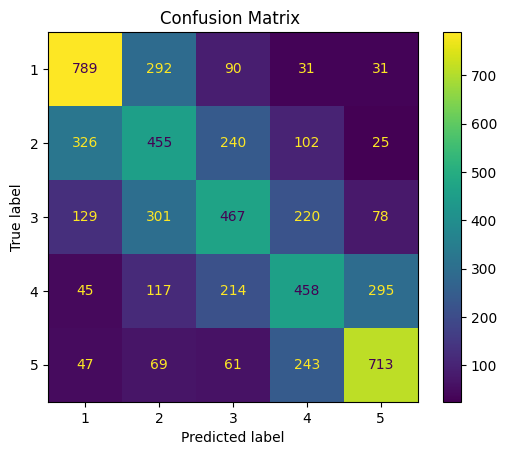

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

#  Multiclass Classification
def evaluate_models_for_cutoff(train):

    print(f"\n=== Processing  ===")
    y = train_df['overall']

    # Train/Validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results_log = []  # each entry will be a dictionary of met


    def evaluate_model(name, model, param_grid, use_proba=True):
        print(f"\n--- {name} ---")
        grid = GridSearchCV(model, param_grid, scoring='f1_macro', cv=5)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print("Best Params:", grid.best_params_)
        

        y_pred = best_model.predict(X_val)
        print("Accuracy:", accuracy_score(y_val, y_pred))
        print("F1 Score:", f1_score(y_val, y_pred, average='macro'))

        if use_proba:
            if hasattr(best_model, "predict_proba"):
                y_scores = best_model.predict_proba(X_val)
            elif hasattr(best_model, "decision_function"):
                y_scores = best_model.decision_function(X_val)
            else:
                y_scores = None

            if y_scores is not None:
                auc_score = roc_auc_score(y_val, y_scores, multi_class='ovr',average='macro')
                print("ROC AUC:", auc_score)
            
        ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
        plt.plot()
        plt.title(f'Confusion Matrix ')
        plt.show()
        
        return {
                "Model": name,
                "Accuracy": accuracy_score(y_val, y_pred),
                "F1 Score": f1_score(y_val, y_pred, average='macro'),
                "AUC": roc_auc_score(y_val, y_scores, multi_class='ovr',average='macro') if use_proba and y_scores is not None else None,
                "Best Params": grid.best_params_,
                "Best Model": grid.best_estimator_
                }
       
    # Best Model
    best_score=0
    best_model=None
    
    # Logistic Regression
    result_LR = evaluate_model(
        name="Logistic Regression",
        model=LogisticRegression(max_iter=1000),
        param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs']}
    )
    results_log.append(result_LR)
    if result_LR["F1 Score"]> best_score:
        best_score=result_LR["F1 Score"]
        best_model=result_LR['Best Model']

    # TAKES TOO LONG TO RUN, CAN CRASH COMPUTER
    # # SVM 
    # result_SVM = evaluate_model( 
    #     name="SVM (RBF)",
    #     model=SVC(probability=True),
    #     param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    #     use_proba=True
    # )

    # results_log.append(result_SVM)
    # if result_SVM["F1 Score"]> best_score:
    #     best_score=result_SVM["F1 Score"]
    #     best_model=result_SVM['Best Model']

    # Random Forest
    result_RF = evaluate_model(
        name="Random Forest",
        model=RandomForestClassifier(),
        param_grid={
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        use_proba=True
    )
    results_log.append(result_RF)
    if result_RF["F1 Score"] > best_score:
        best_score = result_RF["F1 Score"]
        best_model = result_RF["Best Model"]

    # Naive Bayes (Multinomial)
    result_NB = evaluate_model(
            name="Naive Bayes",
            model=MultinomialNB(),
            param_grid={
                'alpha': [0.1, 1.0, 10.0]  # Smoothing parameter
            },
            use_proba=True
    )
    results_log.append(result_NB)

    if result_NB["F1 Score"] > best_score:
        best_score = result_NB["F1 Score"]
        best_model = result_NB["Best Model"]

    return best_model, results_log



# Run evaluations for the models

best_model_multiclass, results_log = evaluate_models_for_cutoff(train_df)
best_models = best_model_multiclass



### Kaggle Multiclass Classification

In [24]:
test_df = pd.read_csv('Test.csv')

print("The Best model result is:", best_models)
#Based on the results above, the best model for cutoff of 1 is BLAH
#best_model_multiclass=best_model

#Predict the label of the test samples
test_text = vectorizer.transform(test_df['reviewText'])
test_predicted = best_model_multiclass.predict(test_text)
test_submission = pd.DataFrame({
    'id': test_df.index,          # or test_df['your_id_column'] if specified
    'label': test_predicted
})
test_submission.to_csv('test_submission_multiclass.csv', index=False)

The Best model result is: MultinomialNB()


## 5. Clustering 
To cluster the product reviews in the test dataset, I created word features from the data and used that for k-means clustering. Clustering will be done by product types, i.e., in this case, the labels will be product categories. Silhouette score and
Rand index were used to analyze the quality of clustering. 

In [31]:
from sklearn.cluster import KMeans

test_cluster = test_df['summary'].fillna('')

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1), min_df=70, max_df=0.7, stop_words='english')
X_cluster = vectorizer.fit_transform(test_cluster)

kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)
s_score = silhouette_score(X_cluster, cluster_labels)
print('The silhouettescore is:',s_score)

The silhouettescore is: 0.7947442086339236


In [33]:
from sklearn.metrics import rand_score

randScore = rand_score(test_df['category'], cluster_labels)
print("Rand Index is:", randScore)

Rand Index is: 0.5371483045615075


## 6. Discussion

As seen above Logistic Regression appeared as the best model for binary classification. Logistic regression is often considered a strong baseline classifier, not necessarily "the best overall," but consistently reliable, interpretable, and efficient. While Naive Bayes (multinomial) appeared best for multiclass classfication. Naive Bayes (especially Multinomial Naive Bayes) is often considered a strong baseline for multiclass classification, particularly in certain domains like text classification (e.g., spam detection, sentiment analysis). While it may not always be the best in every scenario, here’s why it often outperforms or competes well with models like Logistic Regression or Random Forests in multiclass problems.

### Baseline Scores
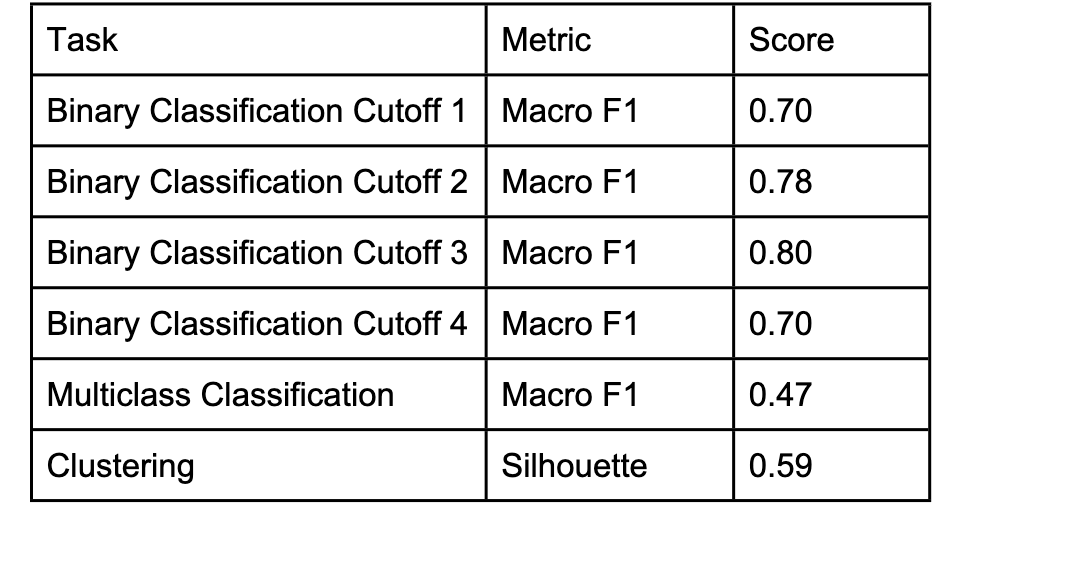



## 7. References

#### Link to dataset
* https://tinyurl.com/22yau9r8
#### Test Feature Extraction 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

#### Machine Learning Models
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/svm.html
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html